In [136]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid')


df_drivers = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/driver_ids.csv')
df_rides = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/ride_timestamps.csv')
df_ride_ids = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/ride_ids.csv')
df_rev = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/Rates.csv')


df_rev = df_rev.dropna()

df_rides = df_rides.sort_values('ride_id')


pivoted = df_rides.pivot(index='ride_id', columns='event', values='timestamp').reset_index()

pivoted = pivoted.sort_values('ride_id')

pivoted['accepted_at'] = pd.to_datetime(pivoted['accepted_at'])
pivoted['arrived_at'] = pd.to_datetime(pivoted['arrived_at'])
pivoted['dropped_off_at'] = pd.to_datetime(pivoted['dropped_off_at'])
pivoted['picked_up_at'] = pd.to_datetime(pivoted['picked_up_at'])
pivoted['requested_at'] = pd.to_datetime(pivoted['requested_at'])
pivoted['requested_at_hour'] = pivoted['requested_at'].dt.hour
pivoted['accepted_at_hour'] = pd.to_datetime(pivoted['accepted_at']).dt.hour
pivoted['accepted_at_day'] = pd.to_datetime(pivoted['accepted_at']).dt.weekday
pivoted['requested_at_day'] = pivoted['requested_at'].dt.weekday

pivoted['weekend'] = [1 if x >=5 else 0 for x in pivoted['requested_at_day'] ]

pivoted['accepted_date'] = pivoted['accepted_at'].dt.date 



df_rides = df_rides.sort_values('ride_id')

pivoted['time_to_pickup'] =  (pivoted['arrived_at'] - pivoted['accepted_at'])

pivoted['time_to_pickup'] = round(pivoted['time_to_pickup']/np.timedelta64(1, 's')/60,2)


merged_rides = pivoted.merge(df_ride_ids, on = 'ride_id')


merged_rides['ride_distance'] = round(merged_rides['ride_distance']*0.00062137,2)
merged_rides['ride_duration'] = round(merged_rides['ride_duration']/60,2)
merged_rides['ride_prime_time'] = round(merged_rides['ride_prime_time']/60,2)


merged_rides['prime_perc'] = round(merged_rides['ride_prime_time']/merged_rides['ride_duration'],2)*100

merged_rides['fare'] = 2+ 1.15 * merged_rides['ride_distance'] + 0.22*merged_rides['ride_duration']+1.75

merged_rides = merged_rides.dropna()

merged_rides = merged_rides.sort_values(by=['driver_id', 'accepted_date'],ascending=[True,True])
#print(merged_rides)


In [137]:
print(df_rides.columns)
print(len(df_rides) - df_rides.count())
print(len(df_ride_ids) - df_ride_ids.count())
print(len(df_drivers) - df_drivers.count())

df_rides = df_rides.dropna()



Index(['ride_id', 'event', 'timestamp'], dtype='object')
ride_id      0
event        0
timestamp    1
dtype: int64
driver_id          0
ride_id            0
ride_distance      0
ride_duration      0
ride_prime_time    0
dtype: int64
driver_id              0
driver_onboard_date    0
dtype: int64


In [138]:
merged_rides = merged_rides.drop(['ride_id'], axis=1)


merged_rides['next_ride_date'] = merged_rides.groupby(['driver_id'])['accepted_date'].shift(-1)


In [139]:
#print(merged_rides)
#print(merged_rides['next_ride_date']-)
merged_rides['diff'] = merged_rides['next_ride_date'] - merged_rides['accepted_date']

merged_rides['diff'] = merged_rides['diff']/np.timedelta64(1, 'D')
merged_rides['churned'] = [1 if x >=30  else 0 for x in merged_rides['diff']]



merged_rides_churned = merged_rides[merged_rides['churned'] == 1]


df_grouped = merged_rides.groupby(['driver_id'], sort=False)['accepted_at'].max()


merged_rides = merged_rides.merge(df_grouped, on = 'driver_id')

merged_rides['accepted_at_last'] = pd.to_datetime(merged_rides['accepted_at_y'])
merged_rides['accepted_at_last_date'] = merged_rides['accepted_at_last'].dt.date 



merged_rides.to_csv(r"C:\Users\akmishra\Desktop\Test\Data\Output_merged.csv")

In [140]:
merged_rides = merged_rides.dropna()
print(merged_rides['next_ride_date'].max())
merged_rides['last_ride_diff'] = merged_rides['next_ride_date'].max() - merged_rides['accepted_at_last_date']




2016-06-26


In [141]:


merged_rides['churned'] = [1 if x >=pd.Timedelta(30,'D')  else 0 for x in merged_rides['last_ride_diff']]


In [142]:
churned_drivers = merged_rides_churned['driver_id'].unique()

#merged_rides[merged_rides['driver_id'] == churned_drivers]['churned']=1
#churned_data = merged_rides[merged_rides['driver_id'] == churned_drivers]

df_churned = merged_rides.loc[merged_rides['driver_id'].isin(churned_drivers)]
df_churned['churned'] = 1

for x in churned_drivers :
    merged_rides.drop(merged_rides[merged_rides['driver_id'] == x].index,inplace=True)

df_total = pd.concat([merged_rides, df_churned], axis=0)


#merged_rides_nochurn.to_csv(r"C:\Users\akmishra\Desktop\Test\Data\Output.csv")





#merged_rides_nochurn.to_csv(r"C:\Users\akmishra\Desktop\Test\Data\Output.csv")


C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [143]:
print(df_total.columns)

Index(['accepted_at_x', 'arrived_at', 'dropped_off_at', 'picked_up_at',
       'requested_at', 'requested_at_hour', 'accepted_at_hour',
       'accepted_at_day', 'requested_at_day', 'weekend', 'accepted_date',
       'time_to_pickup', 'driver_id', 'ride_distance', 'ride_duration',
       'ride_prime_time', 'prime_perc', 'fare', 'next_ride_date', 'diff',
       'churned', 'accepted_at_y', 'accepted_at_last', 'accepted_at_last_date',
       'last_ride_diff'],
      dtype='object')


C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


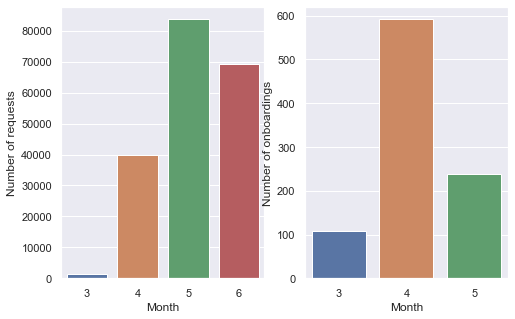

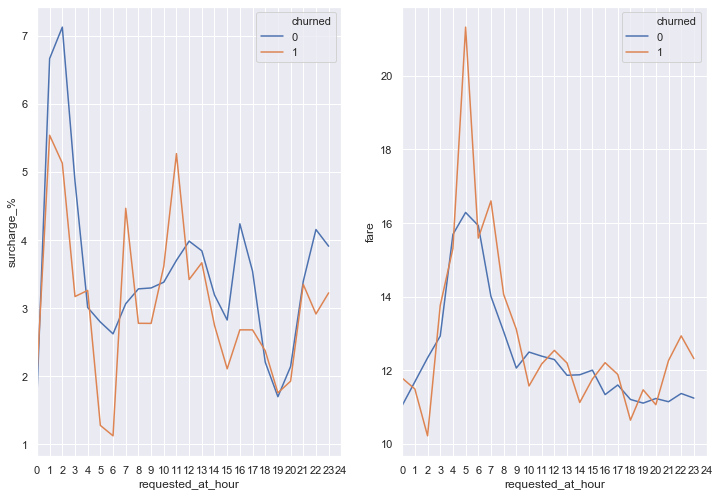

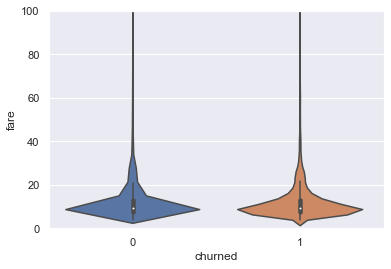

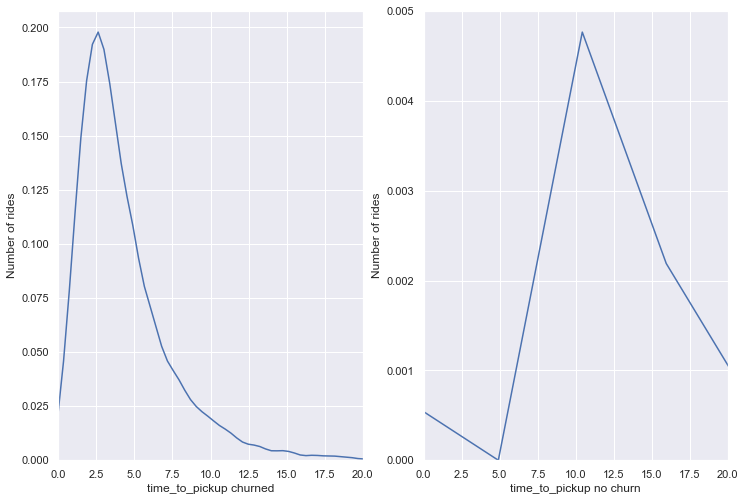

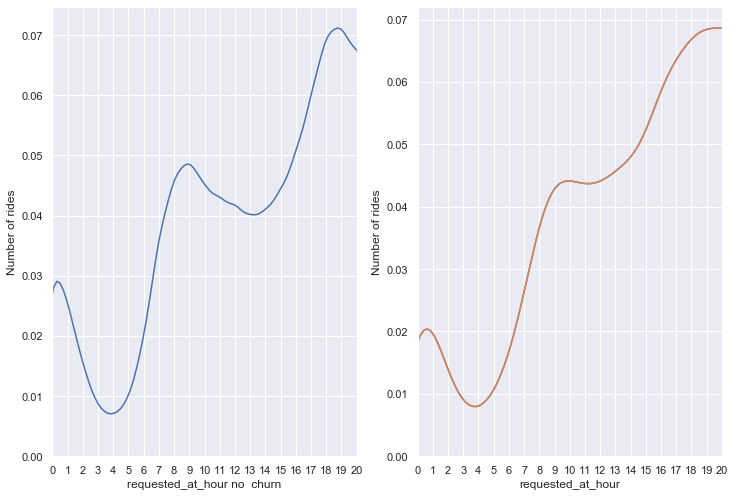

In [145]:
df_total = df_total.dropna()


df_ride_dist = df_total[df_total['ride_distance'] !=0]
df_ride_dist['fare_per_mile'] = df_ride_dist['fare']/df_ride_dist['ride_distance']



fig2, axs2 = plt.subplots(ncols=2)



df_rides['timestamp'] = pd.to_datetime(df_rides['timestamp'])


df_rides['month'] = df_rides['timestamp'].dt.month

df_requests = df_rides[df_rides['event'] == "requested_at"]

sns.countplot(x='month',data=df_requests,ax=axs2[0])
axs2[0].set(xlabel='Month', ylabel='Number of requests')


df_drivers['driver_onboard_date'] = pd.to_datetime(df_drivers['driver_onboard_date'])
df_drivers['driver_onboard_month'] = df_drivers['driver_onboard_date'].dt.month


sns.countplot(x='driver_onboard_month',data=df_drivers,ax=axs2[1])
axs2[1].set(xlabel='Month', ylabel='Number of onboardings')

fig2.set_size_inches(8,5)



import matplotlib.ticker as ticker
fig, ax = plt.subplots(ncols=2)
sns.lineplot(x='requested_at_hour',y='prime_perc',hue='churned', data=df_total[df_total['weekend']==1],err_style =None,ax=ax[0])
ax[0].set(xlabel='requested_at_hour', ylabel='surcharge_%')
ax[0].set_xlim(0,24)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))

sns.lineplot(x='requested_at_hour',y='fare',hue='churned', data=df_total[df_total['weekend']==1],err_style =None,ax=ax[1])
ax[1].set(xlabel='requested_at_hour', ylabel='fare')
ax[1].set_xlim(0,24)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(1))

fig.set_size_inches(12, 8.27)






fig1, ax_line = plt.subplots(ncols=1)
sns.violinplot( ax = ax_line, y = df_total["fare"],x=df_total['churned'] )   
ax_line.set_ylim(0,100)





fig2, axs2 = plt.subplots(ncols=2)
sns.distplot(df_ride_dist[df_ride_dist['churned']==1]['time_to_pickup'], hist=False,ax=axs2[0]);

axs2[0].set(xlabel='time_to_pickup churned', ylabel='Number of rides')

axs2[0].set_xlim(0,20)


sns.distplot(df_ride_dist[df_ride_dist['churned']==0]['time_to_pickup'], hist=False,ax=axs2[1]);

axs2[1].set(xlabel='time_to_pickup no churn', ylabel='Number of rides')

axs2[1].set_xlim(0,20)

fig2.set_size_inches(12, 8.27)
fig4,axs4 = plt.subplots(ncols=2)

sns.distplot(df_ride_dist[df_ride_dist['churned']==0]['requested_at_hour'], hist=False,ax=axs4[0]);

axs4[0].set(xlabel='requested_at_hour no  churn', ylabel='Number of rides')

axs4[0].set_xlim(0,20)
axs4[0].xaxis.set_major_locator(ticker.MultipleLocator(1))


sns.distplot(df_ride_dist[df_ride_dist['churned']==1]['requested_at_hour'], hist=False,ax=axs4[1]);

axs4[1].set(xlabel='requested_at_hour churn', ylabel='Number of rides')

axs4[1].set_xlim(0,20)
axs4[1].xaxis.set_major_locator(ticker.MultipleLocator(1))





sns.distplot(df_ride_dist[df_ride_dist['churned']==1]['requested_at_hour'], hist=False,ax=axs4[1]);





fig4.set_size_inches(12, 8.27)

#sns.catplot(x="weekend",y="prime_perc",kind='box',data=merged_rides,ax=ax_line)
#sns.lineplot(y=merged_rides["prime_perc"], x=merged_rides["requested_at_hour"],ax=ax_line,estimator=np.mean);
#sns.relplot(x="requested_at_hour", y="prime_perc", data=merged_rides,ax=ax_line);




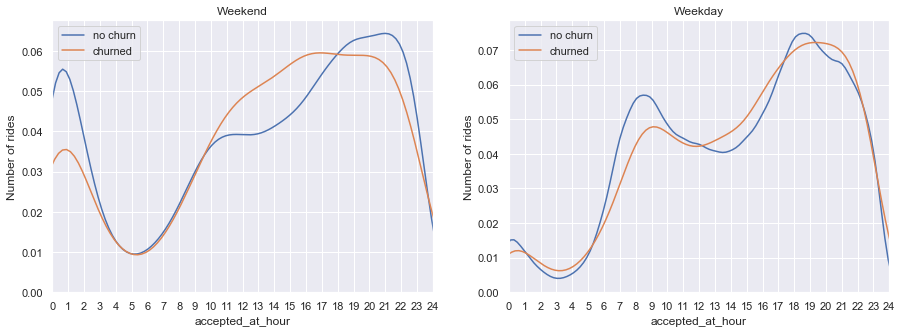

In [69]:
fig5,axs5 = plt.subplots(ncols=2)

sns.distplot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)]['accepted_at_hour'], hist=False,ax=axs5[0],label='no churn').set_title("Weekend");

axs5[0].set(xlabel='accepted_at_hour', ylabel='Number of rides')



sns.distplot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)]['accepted_at_hour'], hist=False,ax=axs5[0],label='churned').set_title("Weekend");



axs5[0].set_xlim(0,24)
axs5[0].xaxis.set_major_locator(ticker.MultipleLocator(1))






sns.distplot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 0)]['accepted_at_hour'], hist=False,ax=axs5[1],label='no churn').set_title("Weekday");

axs5[1].set(xlabel='accepted_at_hour', ylabel='Number of rides')



sns.distplot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 0)]['accepted_at_hour'], hist=False,ax=axs5[1],label='churned').set_title("Weekday");



axs5[1].set_xlim(0,24)
axs5[1].xaxis.set_major_locator(ticker.MultipleLocator(1))

fig5.set_size_inches(15,5)





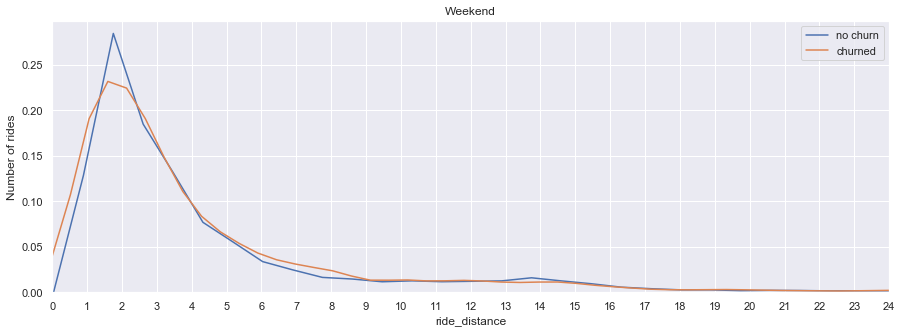

In [125]:

fig6,ax6=plt.subplots(ncols=1)


sns.distplot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)]['ride_distance'], hist=False,ax=ax6,label='no churn').set_title("Weekend");

ax6.set(xlabel='ride_distance', ylabel='Number of rides')



sns.distplot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)]['ride_distance'], hist=False,ax=ax6,label='churned').set_title("Weekend");



ax6.set_xlim(0,24)
ax6.xaxis.set_major_locator(ticker.MultipleLocator(1))

fig6.set_size_inches(15,5)

C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


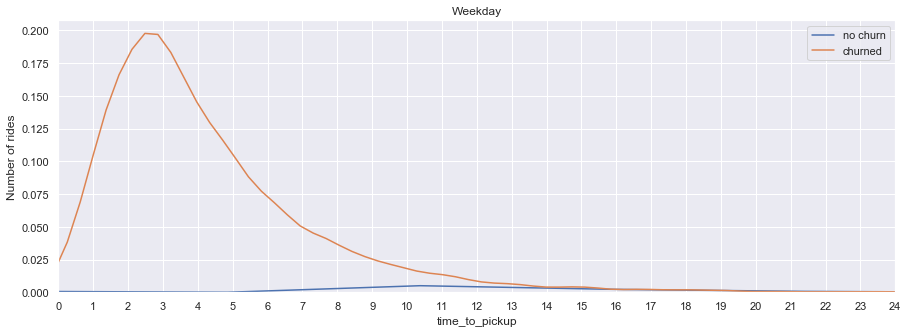

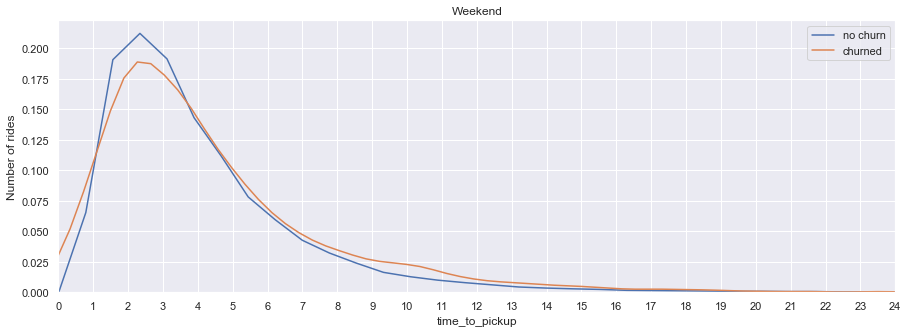

In [71]:
df_ride_dist['MA7_revenue']=df_ride_dist['fare'].rolling(window=7).mean()

fig6,ax6=plt.subplots(ncols=1)


sns.distplot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 0)]['time_to_pickup'], hist=False,ax=ax6,label='no churn').set_title("Weekday");

ax6.set(xlabel='requested_at_hour', ylabel='Number of rides')


sns.distplot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 0)]['time_to_pickup'], hist=False,ax=ax6,label='churned').set_title("Weekday");



ax6.set_xlim(0,24)
ax6.xaxis.set_major_locator(ticker.MultipleLocator(1))

fig6.set_size_inches(15,5)





fig_weekend,ax_weekend=plt.subplots(ncols=1)


sns.distplot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)]['time_to_pickup'], hist=False,ax=ax_weekend,label='no churn').set_title("Weekend");

ax_weekend.set(xlabel='requested_at_hour', ylabel='Number of rides')


sns.distplot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)]['time_to_pickup'], hist=False,ax=ax_weekend,label='churned').set_title("Weekend");



ax_weekend.set_xlim(0,24)
ax_weekend.xaxis.set_major_locator(ticker.MultipleLocator(1))

fig_weekend.set_size_inches(15,5)







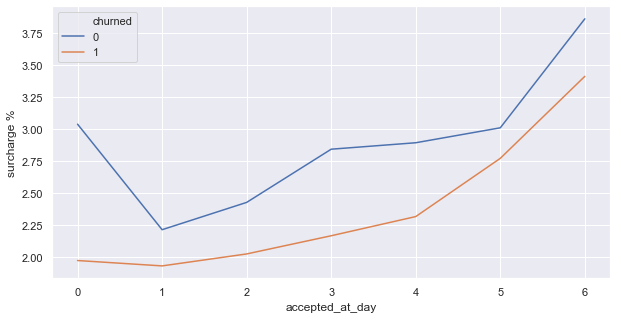

In [147]:
fig15,ax15=plt.subplots(ncols=1)
sns.lineplot(x='accepted_at_day',y='prime_perc',hue='churned', data=df_ride_dist,err_style =None,ax=ax15)
ax15.set(xlabel='accepted_at_day', ylabel='surcharge %')
fig15.set_size_inches(10,5)

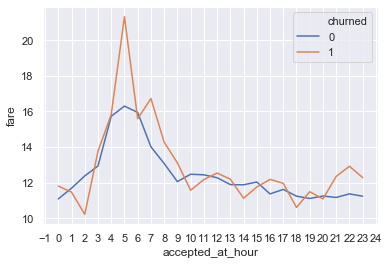

In [73]:
fig7,ax7=plt.subplots(ncols=1)
sns.lineplot(x='accepted_at_hour',y='fare',hue='churned', data=df_ride_dist[df_ride_dist['weekend'] == 1],err_style =None,ax=ax7)
ax7.xaxis.set_major_locator(ticker.MultipleLocator(1))

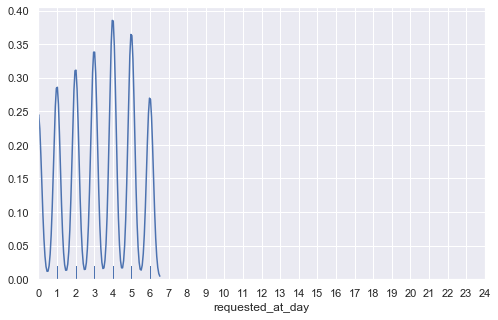

In [74]:
fig8,ax8=plt.subplots(ncols=1)
sns.distplot(df_ride_dist['requested_at_day'],hist=False, rug=True,ax=ax8)
ax8.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax8.set_xlim(0,24)
fig8.set_size_inches(8,5)


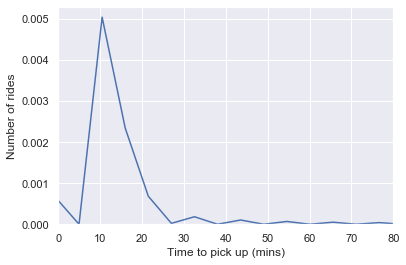

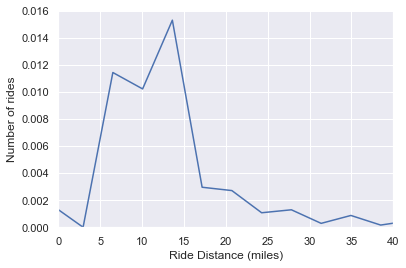

In [75]:
fig1, axs1 = plt.subplots(ncols=1)
sns.distplot(pivoted['time_to_pickup'], hist=False,ax=axs1);

axs1.set(xlabel='Time to pick up (mins)', ylabel='Number of rides')

axs1.set_xlim(0,80)

fig2, axs2 = plt.subplots(ncols=1)
sns.distplot(merged_rides['ride_distance'], hist=False,ax=axs2);

axs2.set(xlabel='Ride Distance (miles)', ylabel='Number of rides')

axs2.set_xlim(0,40)

plt.show()

(0, 200)

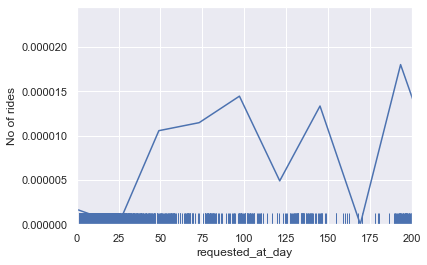

In [76]:
fig9,ax9 = plt.subplots(ncols=1)
sns.distplot(df_ride_dist['fare_per_mile'], hist=False,ax=ax9, rug=True);

ax9.set(xlabel='requested_at_day', ylabel='No of rides')
ax9.set_xlim(0,200)


C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


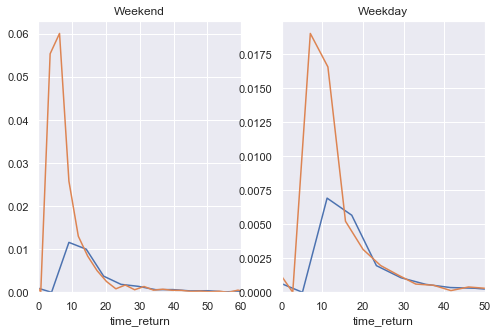

In [77]:
df_ride_dist['time_return'] = df_ride_dist['ride_duration']/df_ride_dist['time_to_pickup']
fig10,ax10 = plt.subplots(ncols=2)
sns.distplot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)]['time_return'], hist=False, rug=False,ax=ax10[0]).set_title("Weekend");

sns.distplot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)]['time_return'], hist=False, rug=False,ax=ax10[0]).set_title("Weekend");
ax10[0].set_xlim(0,60)


sns.distplot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 0)]['time_return'], hist=False, rug=False,ax=ax10[1]).set_title("Weekday");

sns.distplot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 0)]['time_return'], hist=False, rug=False,ax=ax10[1]).set_title("Weekday");
ax10[1].set_xlim(0,50)
fig10.set_size_inches(8,5)


In [78]:
print(df_ride_dist.columns)

Index(['accepted_at_x', 'arrived_at', 'dropped_off_at', 'picked_up_at',
       'requested_at', 'requested_at_hour', 'accepted_at_hour',
       'accepted_at_day', 'requested_at_day', 'weekend', 'accepted_date',
       'time_to_pickup', 'driver_id', 'ride_distance', 'ride_duration',
       'ride_prime_time', 'prime_perc', 'fare', 'next_ride_date', 'diff',
       'churned', 'accepted_at_y', 'accepted_at_last', 'accepted_at_last_date',
       'last_ride_diff', 'fare_per_mile', 'MA7_revenue', 'time_return'],
      dtype='object')


C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
No handles with labels found to put in legend.


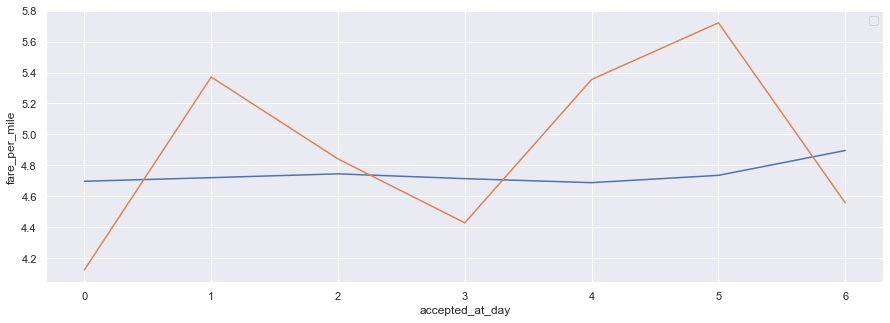

In [79]:
fig11,ax11 = plt.subplots(ncols=1)
#df_ride_dist['MA7_revenue']


df_ride_dist['EMA7_revenue'] = df_ride_dist['fare'].ewm(com=0.5).mean()
sns.lineplot(x='accepted_at_day',y='fare_per_mile', data=df_ride_dist[df_ride_dist['churned']==0],err_style =None,ax=ax11)

sns.lineplot(x='accepted_at_day',y='fare_per_mile', data=df_ride_dist[df_ride_dist['churned']==1],err_style =None,ax=ax11)





ax11.legend()

fig11.set_size_inches(15,5)

In [80]:
print(len(df_ride_dist[df_ride_dist['churned']==0]['driver_id'].unique()))

651


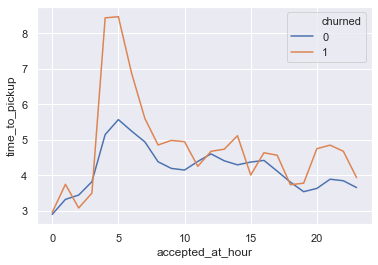

In [86]:
sns.lineplot(x='accepted_at_hour',y='time_to_pickup',hue='churned', data=df_ride_dist[df_ride_dist['weekend'] == 1],err_style =None)

In [91]:
df_ride_dist_corr = df_ride_dist[['accepted_at_hour','time_to_pickup', 'ride_distance', 'ride_duration',
'ride_prime_time', 'prime_perc', 'fare','churned','requested_at_day']]


In [92]:
print(df_ride_dist_corr.corr())

                  accepted_at_hour  time_to_pickup  ride_distance  \
accepted_at_hour          1.000000       -0.034240      -0.065988   
time_to_pickup           -0.034240        1.000000       0.184304   
ride_distance            -0.065988        0.184304       1.000000   
ride_duration            -0.030159        0.136163       0.789976   
ride_prime_time           0.004867        0.042175      -0.048641   
prime_perc                0.005665        0.019514      -0.099471   
fare                     -0.059502        0.179562       0.987453   
churned                   0.013909        0.017299       0.002684   
requested_at_day         -0.061072       -0.023253      -0.002434   

                  ride_duration  ride_prime_time  prime_perc      fare  \
accepted_at_hour      -0.030159         0.004867    0.005665 -0.059502   
time_to_pickup         0.136163         0.042175    0.019514  0.179562   
ride_distance          0.789976        -0.048641   -0.099471  0.987453   
ride_duration

(0, 24)

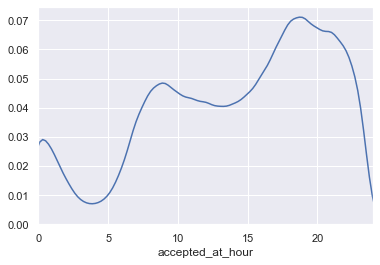

In [102]:
fig12,ax12 = plt.subplots(ncols=1)
sns.distplot(df_ride_dist['accepted_at_hour'], hist=False);
ax12.set_xlim(0,24)

No handles with labels found to put in legend.


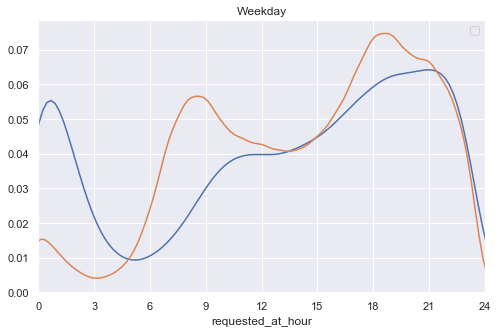

In [122]:
fig13,ax13 = plt.subplots(ncols=1)
sns.distplot(df_ride_dist[df_ride_dist['weekend'] == 1]['requested_at_hour'], hist=False,ax=ax13).set_title("Weekend");
sns.distplot(df_ride_dist[df_ride_dist['weekend'] == 0]['requested_at_hour'], hist=False,ax=ax13).set_title("Weekday");
ax13.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax13.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax13.set_xlim(0,24)
plt.legend()
fig13.set_size_inches(8,5)

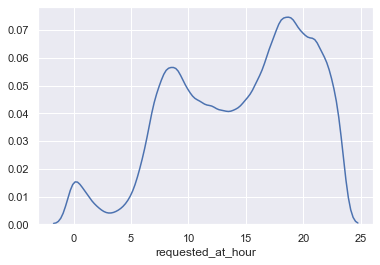

In [104]:
sns.distplot(df_ride_dist[df_ride_dist['weekend'] == 0]['requested_at_hour'], hist=False);